# Entry strategies

The logic to get into a trade is usually different to the one to exit:
- We enter because we have some certainty 
- We exit if the signal did not evolve as expected. 

So the strategies are divided into these 2 types

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
%matplotlib qt

import sys
sys.path.insert(0, "..")  # Adds higher directory to python modules path.

from traphing.data_classes import Velas, Portfolio
from traphing.strategies import Trade
from traphing.strategies.entry import EntryStrategy, CrossingMovingAverages

from traphing.utils import Timeframes, unwrap
import traphing.utils  as ul

from traphing.graph.Gl import gl

folder_images = "./images/python_generated/strategies/"

## Setting up a portfolio

Strategies work on porfolio objects, they are part of them.


In [2]:
symbol_names_list = ["AUDCHF"]
timeframes_list = [Timeframes.M15]
portfolio_name = "my_portfolio"

storage_folder = "../tests/data/storage/"

portfolio = Portfolio(portfolio_name, symbol_names_list, timeframes_list)
portfolio.load_data_from_csv(storage_folder)

start_time = dt.datetime(2019,7,20); end_time = dt.datetime(2019,7,25)
portfolio.set_time_interval(start_time,end_time)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows


# EntryStrategy class

The Velas class provides a basic interface to interact with the OCHLV candlesticks from Technical Analysis data. An object of this class contains the candlestick data for a given symbol and timeframe in a pandas dataframe; and implements a set of functionalities:
<ul>   
    <li> Loading and saving the raw candlestick data from different sources (CSV, SQL..).</li>
    <li> Handling the data updating, missing data, separating trading sessions...</li>
    <li> Technical Analysis indicators: returns, MAs, oscillators...</li>
    <li> Common plots.</li>
</ul>    

## Crossing Moving Averages Entry Strategy

A classic, in this strategy, we compute two MAs of the CLOSE price:
 - The slow MA: 
 - The fast MA: The current trend of the market.

### Instanciating the object

The only mandatory argument is the id, used to reference the signals created by the strategy.

In [3]:
entry_strategy = CrossingMovingAverages("Crossing averages 1", portfolio)

### Setting the strategy parameters

We need to establish the parameters of its MA.

No signal is computed, this information will allow the system to compute it in the future.

In [4]:
symbol_name = symbol_names_list[0]
timeframe = timeframes_list[0]

# Set the paramters
slow_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args": {"n":45}}
fast_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args":{"n":20}}

entry_strategy.set_slow_MA(slow_MA_params)
entry_strategy.set_fast_MA(fast_MA_params)

## Unwrapping the object

In [5]:
unwrap(entry_strategy)

<CrossingMovingAverages>	object has children:
    <str>	strategy_id:	Crossing averages 1
    <Portfolio>	portfolio
    <NoneType>	signal_params_list:	None
    <int>	entry_requests_counter:	0
    <PriorityQueue>	queue
    <list>	series_names
    <dict>	slow_MA
    <dict>	fast_MA

  <dict>	fast_MA has children:
      <str>	symbol_name:	AUDCHF
      <Timeframes>	timeframe:	Timeframes.M15
      <str>	indicator_name:	SMA
      <dict>	args

    <dict>	args has children:
        <int>	n:	20

  <dict>	slow_MA has children:
      <str>	symbol_name:	AUDCHF
      <Timeframes>	timeframe:	Timeframes.M15
      <str>	indicator_name:	SMA
      <dict>	args

    <dict>	args has children:
        <int>	n:	45

  <list>	series_names has children:
      <str>	series_names[0]:	slow_MA
      <str>	series_names[1]:	fast_MA

  <PriorityQueue>	queue has children:
      <int>	maxsize:	0
      <list>	queue
      <lock>	mutex
      <Condition>	not_empty
      <Condition>	not_full
      <Condition>	all_tasks_done
  

## Computing the signals

Once we have the portfolio and parameters of the strategy load, we can compute:
- Its signals from the raw data.
- The BUY SELL
- The dict of actions


In [6]:
entry_strategy_series = entry_strategy.compute_strategy_series()
entry_strategy_series

,slow_MA,fast_MA
Timestamp,,
2019-07-22 00:00:00,NaN,NaN
2019-07-22 00:15:00,NaN,NaN
2019-07-22 00:30:00,NaN,NaN
2019-07-22 00:45:00,NaN,NaN
2019-07-22 01:00:00,NaN,NaN
...,...,...
2019-07-25 22:45:00,0.688035,0.688438
2019-07-25 23:00:00,0.688078,0.688452
2019-07-25 23:15:00,0.688116,0.688484


In [7]:
entry_series = entry_strategy.compute_entry_series()
entry_series

Timestamp
2019-07-22 00:00:00    0.0
2019-07-22 00:15:00    0.0
2019-07-22 00:30:00    0.0
2019-07-22 00:45:00    0.0
2019-07-22 01:00:00    0.0
                      ... 
2019-07-25 22:45:00    0.0
2019-07-25 23:00:00    0.0
2019-07-25 23:15:00    0.0
2019-07-25 23:30:00    0.0
2019-07-25 23:45:00    0.0
Name: Crosses, Length: 384, dtype: float64

### Compute the entry request

In [18]:
entry_requests_queue = entry_strategy.compute_entry_requests_queue()
entry_requests_queue.get()

(Timestamp('2019-07-23 04:00:00'),
 <traphing.strategies.entry._EntryRequest.EntryRequest at 0x7f5b4b177390>)

In [21]:
n_requests = entry_requests_queue.qsize()
entry_requests_dict = dict([entry_requests_queue.get() for i in range(n_requests)])
entries_dates = sorted(list(entry_requests_dict.keys()))
entry_request = entry_requests_dict[entries_dates[0]]
unwrap(entry_request)

<EntryRequest>	object has children:
    <str>	strategy_id:	Crossing averages 1
    <str>	entry_request_id:	11
    <Timestamp>	candlestick_timestamp:	2019-07-23 16:30:00
    <str>	symbol_name:	AUDCHF
    <str>	BUYSELL:	SELL
    <float>	price:	0.6894
    <datetime>	signal_timestamp:	2019-10-20 17:05:42.883533
    <int>	priority:	0
    <int>	recommendedPosition:	1
    <str>	tradingStyle:	dayTrading
    <str>	comments:	Basic Crossing MA man !




In [15]:
entry_requests_dict

{Timestamp('2019-07-23 16:30:00'): <traphing.strategies.entry._EntryRequest.EntryRequest at 0x7f5b4b1b3450>,
 Timestamp('2019-07-24 01:00:00'): <traphing.strategies.entry._EntryRequest.EntryRequest at 0x7f5b4bda39d0>,
 Timestamp('2019-07-24 03:15:00'): <traphing.strategies.entry._EntryRequest.EntryRequest at 0x7f5b4b1bba10>,
 Timestamp('2019-07-25 13:45:00'): <traphing.strategies.entry._EntryRequest.EntryRequest at 0x7f5b4bda3c50>}

### Plotting the results

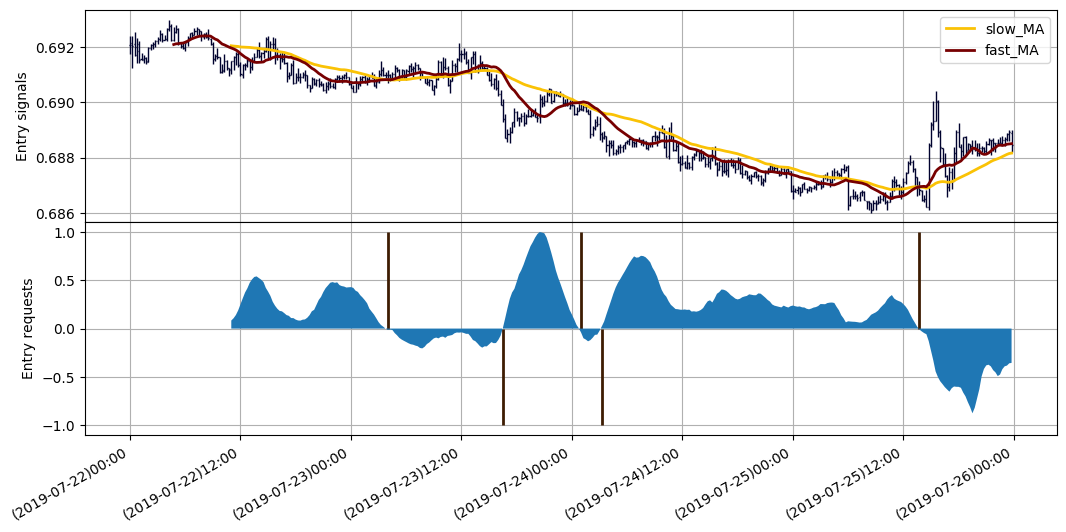

In [16]:
image_name = "entry_strategy.png"; img_path = folder_images + image_name
gl.init_figure()

n_rows, n_cols = 2,1; size_inches = [12, 5]

ax1 = gl.subplot2grid((n_rows, n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows, n_cols),(1,0), sharex = ax1)

portfolio[symbol_name][timeframe].plot_barchart(axes = ax1, labels = ["Entry and Exit strategies", "", "Entry signals"])
gl.plot(entry_strategy_series.index, entry_strategy_series, legend = list(entry_strategy_series.columns), axes =ax1)

difference = entry_strategy_series["slow_MA"] - entry_strategy_series["fast_MA"]
normalized_difference = difference/np.max(np.abs((difference)))
gl.fill_between(entry_strategy_series.index, normalized_difference, 
                labels = ["", "", "Entry requests"], legend = "Normalized signal diff", axes =ax2)
gl.stem(entry_strategy_series.index,entry_series, axes = ax2, legend = "Trades")

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)

## Formulate a trade.

If the Brain decides to perform the trade and it is executed, an instance of the Trade object will be created.
The Trade Class contains all the information about a sucessful trade made. 

Here we will simulate it.


In [17]:
trade = Trade(trade_id = "my_trade12", entry_request = entry_request,
                 trade_price = "0.7", trade_timestamp = dt.datetime.now())
unwrap(trade)

<Trade>	object has children:
    <str>	trade_id:	my_trade12
    <EntryRequest>	entry_request
    <str>	trade_price:	0.7
    <datetime>	trade_timestamp:	2019-10-20 17:02:46.058099
    <str>	BUYSELL:	SELL
    <str>	strategy_id:	Crossing averages 1
    <str>	entry_request_id:	6

  <EntryRequest>	entry_request has children:
      <str>	strategy_id:	Crossing averages 1
      <str>	entry_request_id:	6
      <Timestamp>	candlestick_timestamp:	2019-07-23 16:30:00
      <str>	symbol_name:	AUDCHF
      <str>	BUYSELL:	SELL
      <float>	price:	0.6894
      <datetime>	signal_timestamp:	2019-10-20 17:02:35.342343
      <int>	priority:	0
      <int>	recommendedPosition:	1
      <str>	tradingStyle:	dayTrading
      <str>	comments:	Basic Crossing MA man !




# Interaction with Colliseum